In [1]:
import datastore

import pandas as pd
import numpy as np

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [2]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh, 
                     transTo, transFrom, 
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     temp_pen, wind_velocities, hydroReservoirs], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)
dataset = dataset.astype('float32')

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
# dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])

dataset.rename(columns = {"spotPrice" : "y"}, inplace=True)
dataset.insert(0, "unique_id", 1)
dataset.insert(0, "ds", dataset.index)



dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          54024 non-null  datetime64[ns]
 1   unique_id                   54024 non-null  int64         
 2   y                           54024 non-null  float32       
 3   ConsumptionGWh              54024 non-null  float32       
 4   ProductionGWh               54024 non-null  float32       
 5   waterSE1(MWh)               54024 non-null  float32       
 6   windSE1(MWh)                54024 non-null  float32       
 7   trmSE1MWh                   54024 non-null  float32       
 8   waterSE2(MWh)               54024 non-null  float32       
 9   windSE2(MWh)                54024 non-null  float32       
 10  solSE2MWh                   54024 non-null  float32       
 11  trmSE2MWh          

In [3]:
import torch

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Your Device is {device}.")


train_split = pd.to_datetime('2021-12-31 23:00:00' , format='%Y-%m-%d %H:%M:%S')
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train = dataset.loc[ (dataset.ds <= train_split)]
val = dataset.loc[(dataset.ds > train_split) & (dataset.ds <= val_split)]
test = dataset.loc[dataset.ds > val_split]

h = val['ds'].nunique()

futr_exog_list = dataset.iloc[:, 61:].columns.to_list()
hist_exog_list = dataset.iloc[:, 3:61].columns.to_list()


Your Device is cuda.
True


In [38]:
len(val)

8760

In [45]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import smape

model = [LSTM(
    h = 24*5, 
    loss = MAE(),
    max_steps = 100, 
    
    input_size = 24*5*2,
    
    encoder_n_layers = 1, 
    encoder_hidden_size = 64,
    
    context_size = 10,
    
    decoder_hidden_size = 64,
    decoder_layers = 1,
    
    learning_rate = 0.001,
    scaler_type = "minmax",
    
    futr_exog_list = futr_exog_list,
    hist_exog_list = hist_exog_list
)]
nf = NeuralForecast(models = model, freq = "H")
nf.fit(train, verbose = True)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [53]:
cv_df = nf.cross_validation(val, n_windows = 1 , verbose = True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

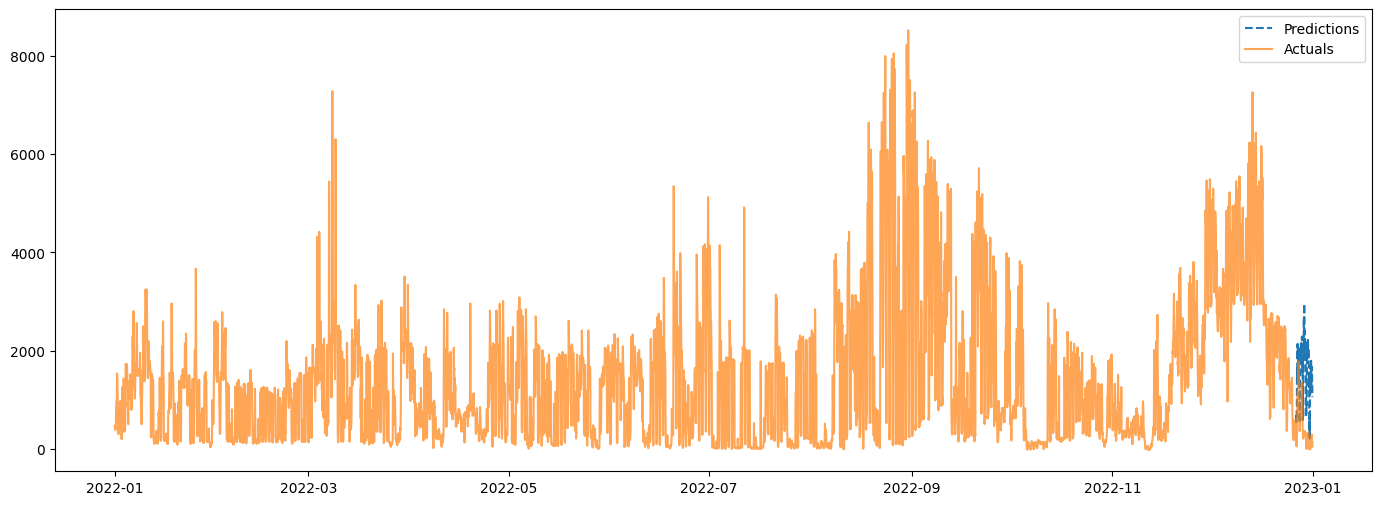

In [54]:
import matplotlib.pyplot as plt
from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy

plt.figure(figsize=(17, 6))
plt.plot(cv_df.ds, cv_df.LSTM, label='Predictions', linestyle='--')
plt.plot(val.ds, val.y, label='Actuals', alpha=0.7)
plt.legend()
plt.show()